# Troubleshooting

Since we released the ConFIG method, we have received a lot of feedback from our users. Among many interesting discussions, we have found many useful tricks that may be helpful for the community. So, if you don't get a good result using ConFIG, please have a check on the following list:

## Are you using different weight models?

Introducing new direction weight models may raise some issues. For example, if you set your weights to $[1,2]$ for a two-loss scenario, the following two scenarios will both satisfy your weight condition:

<p align="center">
<img src="../../assets/troubleshooting/difweightmodel.png" style="zoom: 75%;" />
</p>


Although in both situations the $\mathbf{g}_c$ is a conflict-free direction, as $g_c$ has a positive dot product to both $\mathbf{g}_1$ and $\mathbf{g}_2$​. However, the situation in figure b) might not be the optimal direction. This situation will not occur when you are using the default equal weight models. Thus, we would recommend using the default weighting configuration as much as possible. 

## Are you using momentum-based optimizers?

Momentum-based optimizers (here, we only refer to the optimizer that involves both the first and second momentum, e.g., Adam) might face some issues when you are using the default length model. In the default length model, the magnitude of the update gradient is calculated based on the sum of the projection length of each loss-specific direction, i.e.,

$$
|\mathbf{g}_{\text{ConFIG}}|=\sum_{i=1}^m \mathbf{g}_i^\top\mathbf{g}_u=\sum_{i=1}^m |\mathbf{g}_i|\mathcal{S}_c(\mathbf{g}_i,\mathbf{g}_u).
$$

This means that the final magnitude of the update gradient relies on the "angle" between $\mathbf{g}_i$s and the magnitude of each $\mathbf{g_i}$. So, if one of your loss-specific gradients has a much larger magnitude than other gradients, then it will cover the magnitude distribution of other gradients.

If you are using a momentum-based optimizer, the absolute value of $\mathbf{g}_{\text{ConFIG}}$ actually doesn't matter too much as momentum-based optimizers will adjust the learning rate (length of the update gradient) according to how the gradient changes. If the gradient changes rapidly, then the learning rate will be very small. Thus, if you have a very large loss-specific gradient, the momentum-based optimizers will just change the learning rate according to how the magnitude of this largest gradient changes and ignore the contribution from other gradients (the learning rate also depends on how the angle between loss-specific gradients, $\mathcal{S}_c(\mathbf{g}_i,\mathbf{g}_u)$ changes, of course.).

In our `conflictfree` package, we provide several following [length_model](../../api/length_model/) which can help you to decide which gradients' magnitude you want to track to adjust the learning rate in momentum-based optimizers. Here, we can use a simple example to illustrate the differences btween these length models:

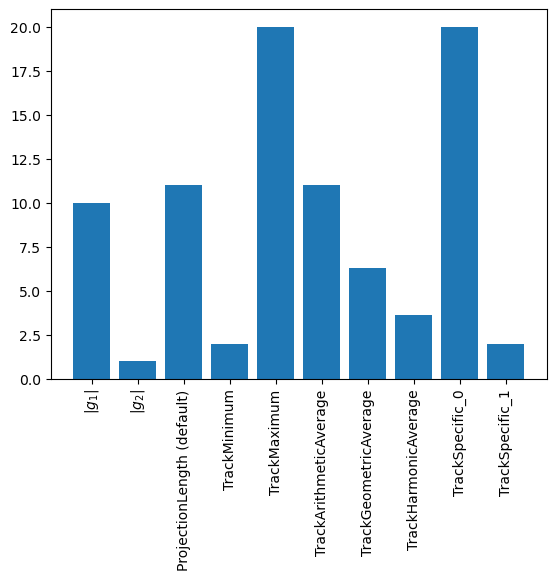

In [23]:
from conflictfree.length_model import *
import matplotlib.pyplot as plt

length_models=[
    ProjectionLength(),
    TrackMinimum(),
    TrackMaximum(),
    TrackArithmeticAverage(),
    TrackGeometricAverage(),
    TrackHarmonicAverage(),
    TrackSpecific(0),
    TrackSpecific(1),
]

grad_1=torch.tensor([0,1.0])
grad_2=torch.tensor([0,1.0])
grad_1=grad_1/torch.norm(grad_1)
grad_2=grad_2/torch.norm(grad_2)
direction_final=grad_1+grad_2
grad_1=grad_1*10
gradients=torch.stack([grad_1,grad_2],dim=0)

lengths=[grad_1.norm().item(),grad_2.norm().item()]
for model in length_models:
    lengths.append(model.get_length(target_vector=direction_final,gradients=gradients).item())
labels=['$|g_1|$',
        '$|g_2|$',
        'ProjectionLength (default)', 
        'TrackMinimum', 'TrackMaximum', 
        'TrackArithmeticAverage', 
        'TrackGeometricAverage', 
        'TrackHarmonicAverage', 
        'TrackSpecific_0', 
        'TrackSpecific_1']

plt.bar(labels,lengths)
plt.xticks(rotation=90)
plt.show()

If your training result is not promising and you know that one of your loss-specific gradients has a much larger magnitude than other gradients, The `TrackMinimum` or `TrackHarmonicMean` might be a good choice worth trying.

## Have you tried to warm up the learning rate?

Usually, the direction of gradients at the start of the training may change rapidly due to the random initialization of the network. This may make it hard for the ConFIG method to find the optimal direction. Thus, we recommend you warm up the learning rate for a few epochs before applying the ConFIG method. This can be easily done by using the `torch.optim.lr_scheduler.LambdaLR` module. Here is an example of a cosine decay learning rate scheduler with warmup:

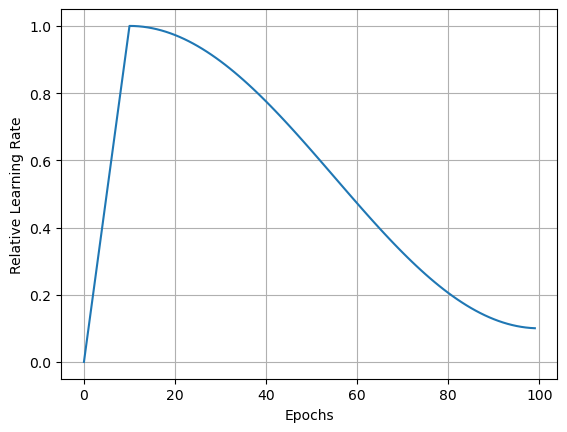

In [27]:
import math
def get_cosine_lambda(initial_lr:float,
                      final_lr:float,
                      epochs:int,
                      warmup_epoch:int):
    """
    Returns a lambda function that calculates the learning rate based on the cosine schedule.

    Args:
        initial_lr (float): The initial learning rate.
        final_lr (float): The final learning rate.
        epochs (int): The total number of epochs.
        warmup_epoch (int): The number of warm-up epochs.

    Returns:
        function: The lambda function that calculates the learning rate.
    """
    def cosine_lambda(idx_epoch):
        if idx_epoch < warmup_epoch:
            return idx_epoch / warmup_epoch
        else:
            return 1-(1-(math.cos((idx_epoch-warmup_epoch)/(epochs-warmup_epoch)*math.pi)+1)/2)*(1-final_lr/initial_lr)
    return cosine_lambda
# from torch.optim.lr_scheduler import LambdaLR
# scheduler = LambdaLR(optimizer, lr_lambda=get_cosine_lambda(initial_lr=1e-3,final_lr=1e-4,epochs=100,warmup_epoch=10))

cos_lambda=get_cosine_lambda(initial_lr=1e-3,final_lr=1e-4,epochs=100,warmup_epoch=10)
lrs=[cos_lambda(i) for i in range(100)]
plt.plot(lrs)
plt.grid()
plt.ylabel("Relative Learning Rate")
plt.xlabel("Epochs")
plt.show()